In [1]:
from WSN import *
import matplotlib.pyplot as plt
from tqdm import tqdm
from wsn_eval import *


In [2]:
def plot_edges(wsn : WSN):
    edges = []
    nodes = list(wsn.anchor_nodes)
    V = len(nodes)
    for ii, i in enumerate(nodes[:-1]):
        for j in nodes[ii+1:]:
            ri = wsn.nodes[i]
            rj = wsn.nodes[j]
            d = dist(ri, rj)
            edge = (d, i, j)
            heappush(edges, edge)
    
    for edge in edges:
        n1 = wsn.nodes[edge[1]]
        n2 = wsn.nodes[edge[2]]
        plt.plot([n1[0], n2[0]], [n1[1], n2[1]], c="orange")
    plt.scatter(wsn.nodes[:, 0], wsn.nodes[:, 1], c="blue")
    plt.xlim((0, 100))
    plt.ylim((0, 100))
    plt.show()


In [2]:
wsn = WSN(100, 7, std=0, D=142)
wsn.reset_nodes()
wsn.reset_anchors({1,2,3,4,5,6})
MST = wsn.find_MST()


7


In [2]:
period = 10 / 100
def modify_results(results):
    new_results = [0] * len(results)
    for i, result in enumerate(results):
        # if result[1] >= 0:
            result0 = result[0]
            result1 = result[1] % period
            if result[1] < 0 or result1 < period / 2:
                result1 -= period
            result1 += np.random.normal(scale=0.5)
            new_results[i] = result0, result1
        # else:
        #     new_results[i] = result[0], result[1] % period - period
    return new_results


In [3]:
def localize_mTDOA_periodic(wsn: WSN):
    r0 = None
    for i in range(wsn.N):
        if i not in wsn.anchor_nodes:
            r0 = wsn.nodes[i]
            break
    if r0 is None:
        raise ValueError("wsn has no target node")
    results = wsn.transmit(0, r0)
    results = modify_results(results)
    H, b = wsn.get_mTDOA_H_and_b(results)
    est_pos = np.linalg.pinv(H) @ b
    return est_pos

def localize_mTDOA_periodic_with_tree(wsn: WSN):
    r0 = None
    for i in range(wsn.N):
        if i not in wsn.anchor_nodes:
            r0 = wsn.nodes[i]
            break
    if r0 is None:
        raise ValueError("wsn has no target node")
    
    MST = wsn.find_MST()
    results = wsn.transmit(0, r0)
    results = modify_results(results)
    H, b = wsn.get_mTDOA_H_and_b_with_tree(results)
    est_pos = np.linalg.pinv(H) @ b
    return est_pos

def localize_mTDOA(wsn: WSN):
    r0 = None
    for i in range(wsn.N):
        if i not in wsn.anchor_nodes:
            r0 = wsn.nodes[i]
            break
    if r0 is None:
        raise ValueError("wsn has no target node")
    results = wsn.transmit(0, r0)
    H, b = wsn.get_mTDOA_H_and_b(results)
    est_pos = np.linalg.pinv(H) @ b
    return est_pos


In [ ]:
# Localize with pairs
cluster_locations = np.array([
    [46, 15],
    [82, 45],
    [72, 84],
    # [36, 73],
    # [17, 48]
])
np.random.seed(1234)
num_clusters = len(cluster_locations)
cluster_size = 3
cluster_scale = 10
N = num_clusters * cluster_size + 1
nodes = np.empty((N, 2))
nodes[0] = [50, 50]
for c, cluster in enumerate(cluster_locations):
    nodes[c * cluster_size + 1:(c+1) * cluster_size + 1] = np.random.normal(loc=cluster, scale=cluster_scale, size=(cluster_size, 2))
clusters = np.array([nodes[c * cluster_size + 1: (c+1) * cluster_size + 1] for c in range(num_clusters)])
r0 = nodes[0]
# wsn.nodes = np.array([
#     [50, 50],
#     [46, 15],
#     [49, 17],
#     [82, 45],
#     [79, 49],
#     [72, 84],
#     [74, 87],
#     [36, 73],
#     [32, 70],
#     [17, 48],
#     [14, 48]
# ])
# N = 11
wsn.nodes = nodes
wsn.N = N
wsn.reset_anchors(set(range(1, N)))
def localize_by_clusters(wsn: WSN):
    H = np.zeros((num_clusters * (cluster_size-1), num_clusters + 3))
    b = np.zeros(num_clusters * (cluster_size-1))
    for c in range(num_clusters):             
        rc = clusters[c][0]
        for n in range(1, cluster_size):
                rn = clusters[c][n]
                # Generate time
                tn = (dist(rn, r0) - dist(rc, r0)) / wsn.c  
                Hn = np.zeros(num_clusters + 3)
                Hn[:2] = 2 * (rn - rc)
                Hn[2] = tn ** 2
                Hn[c + 3] = -2 * tn
                H[c * (cluster_size - 1) + n - 1] = Hn
                b[c * (cluster_size - 1) + n - 1] = rn @ rn - rc @ rc
    # return H, b
    est_pos = np.linalg.pinv(H) @ b
    return est_pos
est_pos = localize_by_clusters(wsn)
print(est_pos)
print(wsn.nodes[0])
# H, b = localize_by_clusters(wsn)


In [6]:
def localize_mTDOA_quotient_estimator(wsn: WSN, period, epochs=5):
    r0 = None
    for i in range(wsn.N):
        if i not in wsn.anchor_nodes:
            r0 = wsn.nodes[i]
            break
    if r0 is None:
        raise ValueError("wsn has no target node")
    results = wsn.transmit(0, r0)
    mresults = modify_results(results)
    for e in range(epochs):
        H, b = wsn.get_mTDOA_H_and_b(mresults)
        est_pos = np.linalg.pinv(H) @ b
        speed = np.sqrt(est_pos[4])
        new_results = [0] * len(mresults)
        for i, result in enumerate(mresults):
            result0, result1 = result
            est_quot = dist(result0, est_pos[:2]) / speed
            



In [6]:
N = 7
wsn = WSN(100, N, verbose=False)
wsn.std = 0
wsn.D = 142


In [7]:
Nrange = range(6, 20)
iterations = 1000
num_err_types = 5
N_errs = np.zeros((len(Nrange), num_err_types))
for i, N in enumerate(Nrange):
    avg_loc_err = 0
    avg_center_err = 0
    avg_est_center_err = 0
    avg_time_err = 0
    avg_speed_err = 0
    avg_errs = np.zeros(num_err_types)
    for it in tqdm(range(iterations)):
        wsn.N = N
        wsn.reset_nodes()
        wsn.reset_anchors(set(range(1, N)))
        # est_pos = localize_mTDOA_periodic(wsn).flatten()
        # est_pos = localize_mTDOA_periodic(wsn).flatten()
        est_pos = wsn.localize_continuous(method="mTDOA", signal_type="fn").flatten()
        est_pos = np.concatenate((est_pos, np.zeros(2)))
        est_pos[3] = max(est_pos[3], 0)
        r0 = wsn.nodes[0]
        x = np.array([*r0, wsn.t0, wsn.c ** 2])
        avg = np.mean(wsn.nodes[1:], axis=0)
        loc_err = dist(est_pos[:2], x[:2])
        center_err = dist(avg, x[:2])
        est_center_err = dist(est_pos[:2], avg)
        time_err = abs(est_pos[2] - x[2])
        speed_err = abs(np.sqrt(est_pos[3]) - np.sqrt(x[3]))

        avg_errs += np.array([loc_err, center_err, est_center_err, time_err, speed_err])
    avg_errs /= iterations
    N_errs[i] = avg_errs




 69%|██████▊   | 687/1000 [02:46<01:20,  3.90it/s]d:\Repositories\WSN-Localization\mutual_information.py:104: RuntimeWarning: divide by zero encountered in log
  mi = -0.5 * np.log(np.linalg.det(cor))
 80%|████████  | 803/1000 [03:12<00:45,  4.36it/s]d:\Repositories\WSN-Localization\mutual_information.py:104: RuntimeWarning: invalid value encountered in log
  mi = -0.5 * np.log(np.linalg.det(cor))
  4%|▍         | 39/1000 [00:23<09:30,  1.68it/s]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "d:\Repositories\WSN-Localization\vwsn\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\brian\AppData\Local\Temp\ipykernel_13488\2302491801.py", line 18, in <cell line: 5>
    est_pos = wsn.localize_continuous(method="mTDOA", signal_type="fn").flatten()
  File "d:\Repositories\WSN-Localization\WSN.py", line 410, in localize_continuous
    def localize_continuous(self, method="mTDOA", signal_type="osc", epochs=1, show_error="Error"):
  File "d:\Repositories\WSN-Localization\WSN.py", line 402, in localize_fn_continuous
  File "d:\Repositories\WSN-Localization\WSN.py", line 288, in get_mTDOA_H_and_b
    if H.ndim == 1:
  File "<__array_function__ internals>", line 180, in concatenate
numpy.AxisError: axis 1 is out of bounds for array of dimension 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):

In [9]:
np.save("N_errs.npy", N_errs)

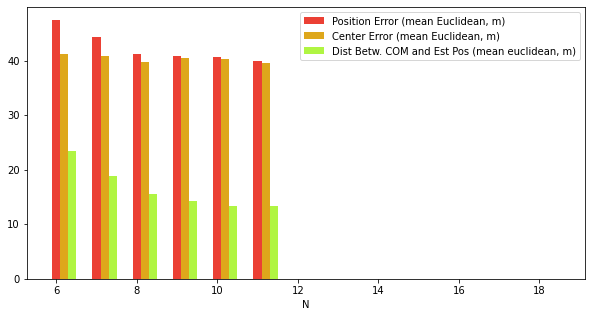

In [8]:
# Plotting
barWidth = 0.2
fig = plt.subplots(figsize=(10, 5))
colors = ("#eb4034", "#dea71b", "#b0f542", "#0d8c4a", "#0d338c")
labels = ("Position Error (mean Euclidean, m)",  "Center Error (mean Euclidean, m)", "Dist Betw. COM and Est Pos (mean euclidean, m)","Time Error (mean, s)", "Speed Error (mean, m/s)")

# for i in range(0, num_err_types):
b = 0
for i in [0,1,2]:
    br = list(Nrange)
    # br = [x - 1 for x in br]
    br = [x - 1 + barWidth * b for x in br]
    plt.bar(br[1:], N_errs[1:, i], color=colors[i], width=barWidth, label=labels[i])
    b += 1

plt.legend()
# plt.ylabel(labels[i])
plt.xlabel("N")
# plt.legend()
plt.show()

In [117]:

N = 7
wsn.N = N
wsn.reset_nodes()
wsn.reset_anchors(set(range(1, N)))
est_pos = localize_mTDOA(wsn).flatten()


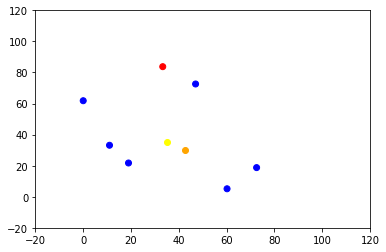

In [118]:
plt.scatter(wsn.nodes[:, 0], wsn.nodes[:, 1], c=["blue" if i in wsn.anchor_nodes else "red" for i in range(wsn.N)], label="anchors")
plt.scatter(*est_pos[:2], c="orange", label="est_pos")
avg = np.mean(wsn.nodes[1:], axis=0)
plt.scatter(*avg, c="yellow", label="centerpoint")
plt.xlim((-20, 120))
plt.ylim((-20, 120))
plt.show()
